In [1]:
using Flight.FlightCore.Systems
using Flight.FlightCore.Plotting

using Flight.FlightPhysics.Geodesy
using Flight.FlightPhysics.Kinematics
using Flight.FlightComponents.Aircraft
using Flight.FlightComponents.Control
using Flight.FlightAircraft.C172FBW
using Flight.FlightAircraft.C172

using ControlSystems
using RobustAndOptimalControl

In [2]:
ac = Cessna172FBWBase(NED()) |> System #linearization requires NED kinematics

#same mass in all cases
fwd_cg_pld = C172.PayloadU(m_pilot = 100, m_copilot = 100, m_baggage = 0)
aft_cg_pld = C172.PayloadU(m_pilot = 50, m_copilot = 50, m_baggage = 100)
mid_cg_pld = C172.PayloadU(m_pilot = 75, m_copilot = 75, m_baggage = 50)

design_condition_1 = C172FBW.TrimParameters(
    Ob = Geographic(LatLon(), HOrth(1000)),
    EAS = 25.0,
    γ_wOb_n = 0.0,
    x_fuel = 0.5,
    flaps = 1.0,
    payload = mid_cg_pld)

design_condition_2 = C172FBW.TrimParameters(
    Ob = Geographic(LatLon(), HOrth(1000)),
    EAS = 55.0,
    γ_wOb_n = 0.0,
    x_fuel = 0.5,
    flaps = 0.0,
    payload = mid_cg_pld)

ail_rud_MIMO = named_ss(ac, design_condition_2; model = :lat);

## 1. Roll Rate

In [3]:
P_a2p = ail_rud_MIMO[:p, :aileron_cmd]
zeros_p = zpkdata(P_a2p)[1][1]
ωn_p, ζ_p, poles_p = damp(P_a2p)
zeros_p |> display
poles_p |> display
ωn_p |> display
ζ_p |> display

5-element Vector{ComplexF64}:
   -0.7356908386742655 + 2.6922409948633863im
   -0.7356908386742655 - 2.6922409948633863im
  -0.10976015775064289 + 0.0im
 0.0014105434226332348 + 0.0im
 -7.144161331083059e-6 + 0.0im

11-element Vector{ComplexF64}:
 1.0474214396863987e-6 + 0.0im
  -0.02820593453671514 + 0.0im
   -0.1081000246927404 + 0.0im
   -0.7349754104430887 + 2.939344545279916im
   -0.7349754104430887 - 2.939344545279916im
   -11.541816035671967 + 0.0im
    -49.99999999999999 + 0.0im
    -37.69911184307752 + 50.26548245743669im
    -37.69911184307752 - 50.26548245743669im
    -37.69911184307752 + 50.26548245743669im
    -37.69911184307752 - 50.26548245743669im

11-element Vector{Float64}:
  1.0474214396863987e-6
  0.02820593453671514
  0.1081000246927404
  3.0298407895172947
  3.0298407895172947
 11.541816035671967
 49.99999999999999
 62.83185307179586
 62.83185307179586
 62.83185307179586
 62.83185307179586

11-element Vector{Float64}:
 -1.0
  1.0
  1.0
  0.2425788882986763
  0.2425788882986763
  1.0
  1.0
  0.5999999999999999
  0.5999999999999999
  0.5999999999999999
  0.5999999999999999

We have:
- A very fast real pole corresponding to the $\beta$ filter.
- Two pairs of very fast complex poles, corresponding to the aileron and rudder actuators
- A fast real pole, corresponding to the roll subsidence mode.
- A pair of slow, lightly damped complex poles, corresponding to the Dutch roll mode
- A slow pole, corresponding to the spiral mode. Depending on the operating condition this pole can be stable or unstable, and it is very close to a slow zero.
- A slow stable real pole, cancelled by a zero, don't know where it comes from.
- A pole at the origin, cancelled by a corresponding zero.

The near-cancellation of the spiral pole with the nearby zero suggests that the spiral mode is not fully controllable by a SISO roll rate to aileron control path only. It also means that its short-term effect in the dynamic response is negligible for the purposes of roll rate control design. We can expect that by adding sideslip control to roll rate control later on we will be able to stabilize the spiral mode.

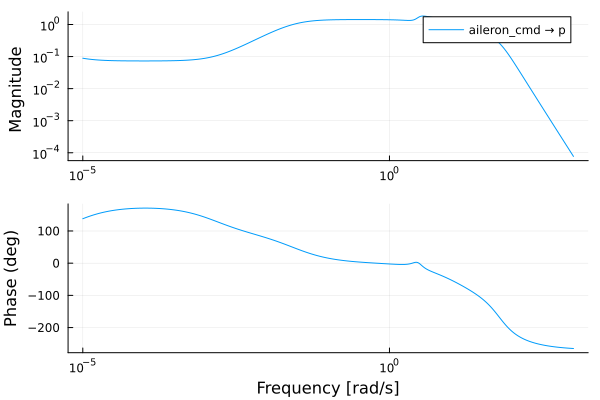

In [4]:
bodeplot(P_a2p)

┌ Warning: Keyword argument hover not supported with Plots.GRBackend().  Choose from: annotationcolor, annotationfontfamily, annotationfontsize, annotationhalign, annotationrotation, annotations, annotationvalign, arrow, aspect_ratio, axis, background_color, background_color_inside, background_color_outside, background_color_subplot, bar_width, bins, bottom_margin, camera, clims, color_palette, colorbar, colorbar_entry, colorbar_scale, colorbar_title, colorbar_titlefont, colorbar_titlefontcolor, colorbar_titlefontrotation, colorbar_titlefontsize, connections, contour_labels, discrete_values, fill, fill_z, fillalpha, fillcolor, fillrange, fillstyle, flip, fontfamily, fontfamily_subplot, foreground_color, foreground_color_axis, foreground_color_border, foreground_color_grid, foreground_color_subplot, foreground_color_text, formatter, framestyle, grid, gridalpha, gridlinewidth, gridstyle, group, guide, guidefont, guidefontcolor, guidefontfamily, guidefonthalign, guidefontrotation, guidefo

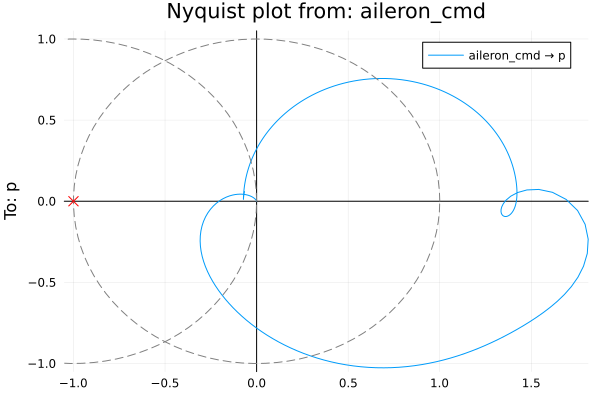

In [5]:
nyquistplot(P_a2p; unit_circle = true, Ms_circles = [1.0])
# plot!(ylims = (-2,2), xlims = (-2,2))

Because the open loop transfer function may be unstable, we cannot apply the final value theorem here. We will inspect the step response directly by simulation.

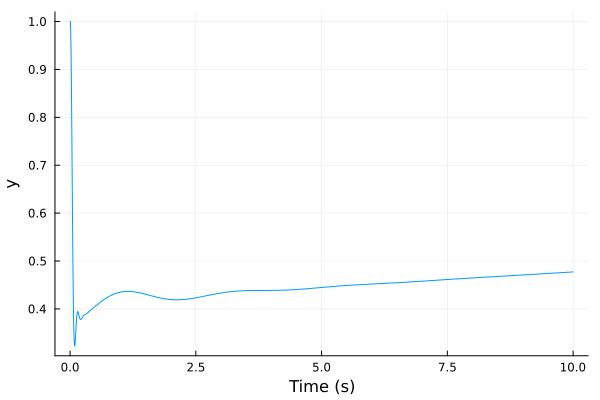

In [6]:
ε_a2p_cl = 1/(1+tf(P_a2p))
step(ε_a2p_cl, 10) |> plot

Even though the system is unstable, the PID optimization will still yield results:
- If the loop transfer function has unstable poles, we need one or more encirclements of (-1, 0) for it to be stable. Therefore, maintaining a minimum distance 1/|Ms| to (-1, 0) is no longer a guarantee of stability. But it turns out that if we consider the subsystem without the unstable poles, it still provides information about its short-term stability. 
- Both $\int{e}$ and $e_f$ will of course be infinite over a long enough time window, because no matter how diminished the influence of the unstable poles by corresponding zeros, they will cause divergence in the end. However, for a sufficiently small simulation time window, where their contribution is still negligible, the error metrics can still be minimized by the choice of PID parameters.

Basically, we are optimizing the PID neglecting the effect of the unstable poles

In [7]:
t_sim_p = 5
settings = PIDOpt.Settings(; t_sim = t_sim_p, maxeval = 5000)
weights = PIDOpt.Metrics(; Ms = 1, ∫e = 10, ef = 2)

params_0 = PIDOpt.Params(; k_p = 1, k_i = 10, k_d = 0.025, τ_f = 0.01)
# params_0 = PIDOpt.Params()
p_results = PIDOpt.optimize_PID(P_a2p; params_0, settings, weights, global_search = false)

@show p_results.params.k_p
@show p_results.params.k_i
@show p_results.params.k_d
@show p_results.params.T_i
@show p_results.params.T_d
@show p_results.metrics

# exit_flag |> display
# cost |> display
# metrics_opt |> display
# q_PID_params_opt |> display
# PID_opt |> display

p_PID = PIDOpt.build_PID(p_results.params)
C_p2a = p_PID
C_p2a = named_ss(C_p2a, :pcmp; u = :p_err, y = :aileron_cmd);


p_results.params.k_p = 0.4233196686799135
p_results.params.k_i = 9.902978346457955
p_results.params.k_d = 0.006978768451529279
p_results.params.T_i = 0.042746702443444626
p_results.params.T_d = 0.016485811947486346
p_results.metrics = [1.1752698724867492, 0.022777676134908834, 0.002463677219715299]


StepInfo:
Initial value:     0.000
Final value:       0.998
Step size:         0.998
Peak:              1.090
Peak time:         0.249 s
Overshoot:          9.31 %
Undershoot:         0.00 %
Settling time:     0.710 s
Rise time:         0.114 s


isstable(L_p) = false

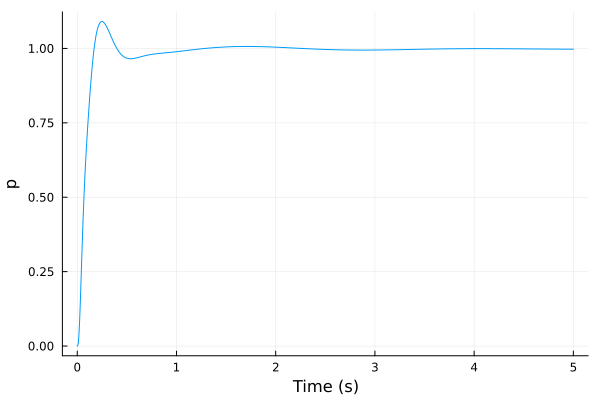

In [8]:
#steady-state error for a unit step input, now zero
L_p = series(C_p2a, P_a2p)
@show isstable(L_p)
# ε_p_cl = 1/(1+tf(L_p))
# @show ε_p_cl(0)

T_p = output_comp_sensitivity(P_a2p, C_p2a) #this is the closed loop transfer function
T_p_step = step(T_p, t_sim_p)
stepinfo(T_p_step) |> display
T_p_step |> plot

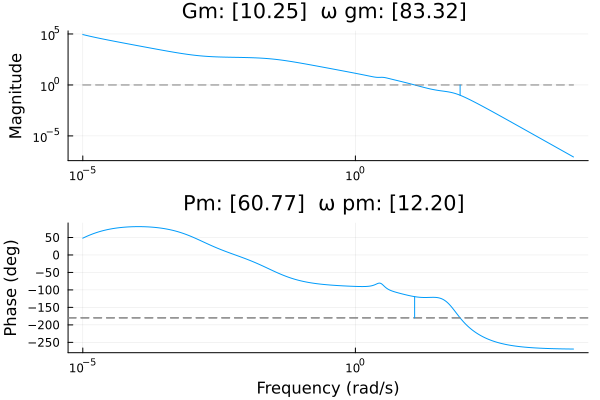

In [9]:
marginplot(L_p)

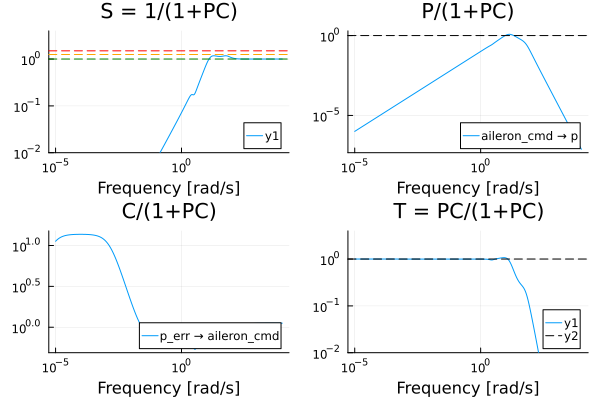

In [10]:
gangoffourplot(P_a2p, C_p2a)

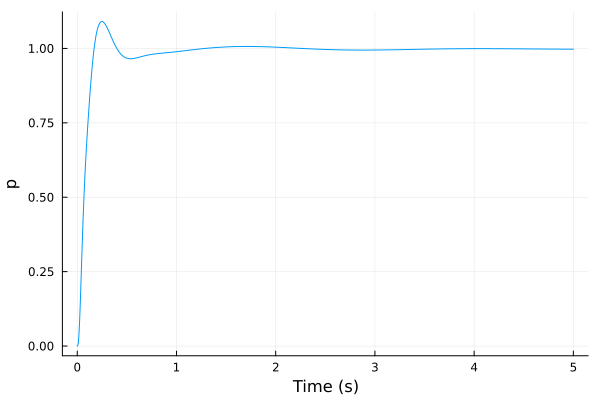

In [11]:
psum = sumblock("p_err = p_dmd - p")
p_rud_MIMO = connect([psum, C_p2a, ail_rud_MIMO], [:p_err=>:p_err, :p=>:p, :aileron_cmd=>:aileron_cmd], w1 = [:p_dmd, :rudder_cmd], z1 = ail_rud_MIMO.y)

#check we get the same response as with the SISO closed loop
pdmd2p = p_rud_MIMO[:p, :p_dmd]
step(pdmd2p, t_sim_p) |> plot

## 2. Sideslip

The starting plant is the lateral dynamics augmented with embedded roll rate control.

In [13]:
P_r2β = p_rud_MIMO[:β, :rudder_cmd]
zpk(P_r2β) |> display
poles(P_r2β) |> display

P_r2β = minreal(P_r2β, 1e-2)
poles(P_r2β) |> display

TransferFunction{Continuous, ControlSystemsBase.SisoZpk{Float64, ComplexF64}}
                                                          (1.0s + 103.01846813265823)(1.0s^2 + 65.178596020903s + 3530.236353798837)(1.0s + 36.09360990401809)(1.0s^2 + 16.33330452450108s + 218.8675510328739)(1.0s + 0.11004200912383143)(1.0s - 0.0014335722015680586)(1.0s + 7.14363389695593e-6)
-179.76804272275436--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                   (1.0s + 108.27429893464321)(1.0s^2 + 75.39822368615503s + 3947.8417604357433)(1.0s^2 + 62.61316404441381s + 3805.225129304537)(1.0s^2 + 15.992847302254145s + 184.84106165191295)(1.0s^2 + 1.557616064027584s + 7.7868128862442125)(1.0s + 0.10976962303749911)(1.0s + 7.1440803084

12-element Vector{ComplexF64}:
   -108.27429893464321 + 0.0im
   -31.306582022206904 + 53.1518866211856im
   -31.306582022206904 - 53.1518866211856im
    -7.996423651127072 + 10.99537495693569im
    -7.996423651127072 - 10.99537495693569im
    -0.778808032013792 + 2.6796027570360157im
    -0.778808032013792 - 2.6796027570360157im
  -0.10976962303749911 + 0.0im
 0.0014076579351808313 + 0.0im
 -7.144080308407504e-6 + 0.0im
    -37.69911184307752 + 50.26548245743669im
    -37.69911184307752 - 50.26548245743669im

10-element Vector{ComplexF64}:
  -108.27429893446501 + 0.0im
   -37.69911184307752 + 50.265482457436775im
   -37.69911184307752 - 50.265482457436775im
  -31.306582013387683 + 53.15188660693829im
  -31.306582013387683 - 53.15188660693829im
   -7.996422182512061 + 10.995368715798982im
   -7.996422182512061 - 10.995368715798982im
   -0.778794369422917 + 2.6795921720273297im
   -0.778794369422917 - 2.6795921720273297im
 -0.10978623416004778 + 0.0im

10-element Vector{ComplexF64}:
  -108.27503483477514 + 0.0im
   -37.70178118482663 + 50.25025941973022im
   -37.70178118482663 - 50.25025941973022im
   -31.29507827573282 + 53.14883918051642im
   -31.29507827573282 - 53.14883918051642im
    -8.00557633180916 + 10.987849319336917im
    -8.00557633180916 - 10.987849319336917im
   -0.778086879440604 + 2.98425834944519im
   -0.778086879440604 - 2.98425834944519im
 -0.10982580703205423 + 0.0im

ε_ir2β_cl(0) = [0.8189727116534831;;]


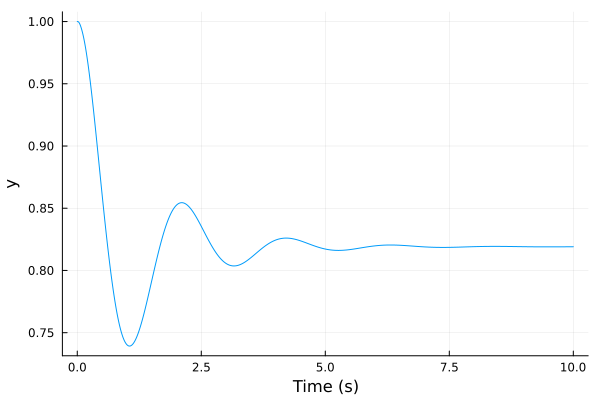

In [14]:
#the DC gain is negative. this makes sense, given that we have: act.rudder↑ ->
#aero.r↓ -> yaw↑ -> β↓. therefore, the first thing we need in the forward path
#for tracking a β command is a sign inversion in the rudder command right before
#the plant. it will take an inverted rudder_cmd from the compensator and output
#a rudder_cmd with the correct sign
rudder_inv = named_ss(ss(-1), u=:rudder_cmd_inv, y=:rudder_cmd)
ir2β = series(rudder_inv, P_r2β)

#output error transfer function for a unit feedback closed loop
ɛ_ir2β_cl = 1/(1+tf(ir2β))
ɛ_ir2β_cl |> poles |> display
@show ɛ_ir2β_cl(0) #DC gain is now positive
step(ɛ_ir2β_cl, 10) |> plot

#of course, the response is unsatisfactory, but we at least see that the sign is
#now right: the error is reduced from its initial value of 1

In [15]:
#our optimization target plant is NOT simply P_r2β, it must include the sign inversion
P_β_opt = -P_r2β

t_sim_β = 5
settings = PIDOpt.Settings(; t_sim = t_sim_β, maxeval = 5000)
weights = PIDOpt.Metrics(; Ms = 1, ∫e = 10, ef = 2)
# params_0 = PIDOpt.Params(; k_p = 5, k_i = 30, k_d = 0.5, τ_f = 0.01)
params_0 = PIDOpt.Params()
β_results = PIDOpt.optimize_PID(P_β_opt; params_0, settings, weights, global_search = false)
β_PID = PIDOpt.build_PID(β_results.params)

@show β_results.params.k_p
@show β_results.params.T_i
@show β_results.params.T_d
@show β_results.metrics


β_results.params.k_p = 6.991363243907488
β_results.params.T_i = 0.18994945951311099
β_results.params.T_d = 0.6652930596478558
β_results.metrics = [1.1660940452888848, 0.02464097612111801, 2.042659930645563e-5]


3-element Flight.FlightComponents.Control.PIDOpt.Metrics{Float64} with indices SOneTo(3):
 1.1660940452888848
 0.02464097612111801
 2.042659930645563e-5

In [16]:
β_PID = PIDOpt.build_PID(β_results.params)
C_β2r = -β_PID
C_β2r = named_ss(C_β2r, :βcmp; u = :β_err, y = :rudder_cmd);

StepInfo:
Initial value:     0.000
Final value:       1.000
Step size:         1.000
Peak:              1.000
Peak time:         2.927 s
Overshoot:          0.00 %
Undershoot:         0.00 %
Settling time:     0.427 s
Rise time:         0.237 s


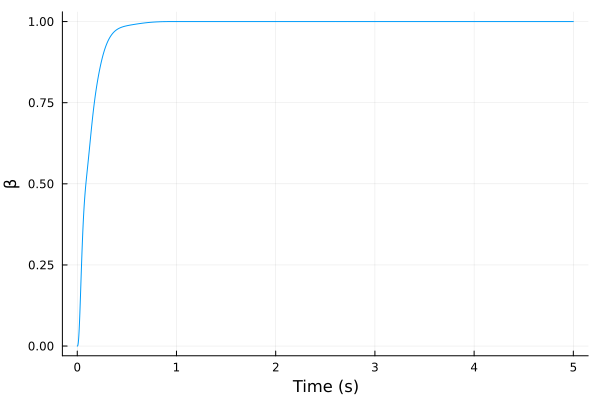

In [17]:
L_β = series(C_β2r, P_r2β)

T_β = output_comp_sensitivity(P_r2β, C_β2r) #this is the closed loop transfer function
T_β_step = step(T_β, t_sim_β)
stepinfo(T_β_step) |> display
T_β_step |> plot
# poles(T_β)

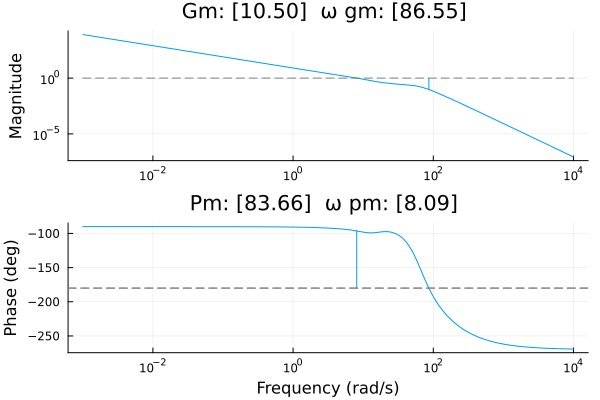

In [18]:
marginplot(L_β)

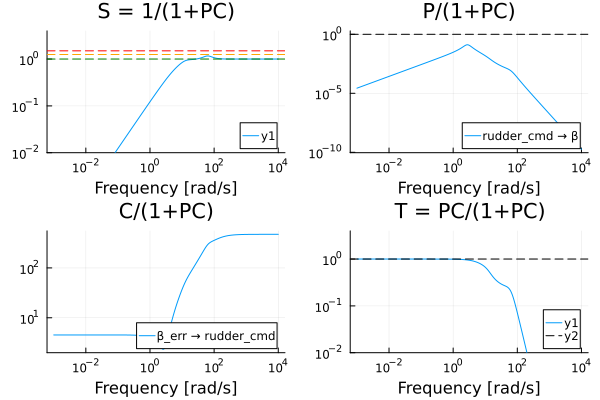

In [19]:
gangoffourplot(P_r2β, C_β2r)

In [22]:
βsum = sumblock("β_err = β_dmd - β")
p_β_MIMO = connect([βsum, C_β2r, p_rud_MIMO], [:β_err=>:β_err, :β=>:β, :rudder_cmd=>:rudder_cmd], w1 = [:p_dmd, :β_dmd], z1 = p_rud_MIMO.y)

#check we get the same response as with the SISO closed loop
βdmd2β = p_β_MIMO[:β, :β_dmd]
step(βdmd2β, 10) |> plot

#we see that the unstable spiral pole is (all but) naturally cancelled
zpk(βdmd2β) |> display

#p_β_MIMO is our new plant baseline: lateral dynamics with embedded roll rate
#and sideslip control and p_dmd and β_dmd as inputs
p_β_MIMO

TransferFunction{Continuous, ControlSystemsBase.SisoZpk{Float64, ComplexF64}}
                                                    (1.0s + 103.01846813265801)(1.0s^2 + 65.17859602090303s + 3530.2363537988426)(1.0s + 36.09360990401801)(1.0s^2 + 16.333304524501095s + 218.8675510328739)(1.0s^2 + 1.5587981658752006s + 7.7959608876709705)(1.0s + 0.1100420091238314)(1.0s - 0.0014335722015693135)(1.0s + 7.143633896950214e-6)
84872.43125736427-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                 (1.0s + 113.37868480723334)(1.0s + 101.61963805713533)(1.0s^2 + 69.3274572022572s + 3628.160255786538)(1.0s^2 + 55.41246500137872s + 4006.219431931766)(1.0s + 8.2478174344849)(1.0s^2 

NamedStateSpace{Continuous, Float64}
A = 
      0.0                  4.0               0.0                 0.0                0.0                     0.0                    0.0                     0.0                     0.0                         0.0                      0.0                   0.0                   0.0                   0.0
      0.0               -100.0               0.0                 0.0                0.0                     0.0                    0.0                     0.0                     4.163081571354292e-21      -4.433994425831213        0.0                   0.0                   0.0                   0.0
      0.0                  0.0               0.0                 8.0                0.0                     0.0                    0.0                     0.0                     0.0                         0.0                      0.0                   0.0                   0.0                   0.0
      0.0                  0.0               0.0    